<a href="https://colab.research.google.com/github/ziatdinovmax/ActiveChannelLearning/blob/main/hmcDKL_channels_PFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Channel Learning with Fully Bayesian Deep Kernel Learning

*Notebook prepared by Maxim Ziatdinov (March 2022)*

- BEPFM and BEPS data acquired by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)
- Analyses of BE- data by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)
- PTO sample from [Hiroshi Funakubo](https://scholar.google.co.jp/citations?user=12EJj9gAAAAJ&hl=ja)


In this notebook, we show how to learn the channel with best predictive capability in DKL-based active learning.

## **Import and Download data**

In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax@v0.0.3
!pip install -U gdown

In [3]:
from warnings import filterwarnings

import numpy as np
import matplotlib.pyplot as plt

import gpax
import jax.numpy as jnp

from sklearn.model_selection import train_test_split

filterwarnings("ignore", category=UserWarning)

gpax.utils.enable_x64()

In [4]:
#@title Load helper functions  🛠️ { form-width: "20%" }
from typing import Tuple

def make_window(imgsrc: np.ndarray, window_size: int,
                xpos: int, ypos: int) -> np.ndarray:
    """
    Returns the portion of the image within the window given the
    image (imgsrc), the x position and the y position
    """
    imgsrc = imgsrc[int(xpos-window_size/2):int(xpos+window_size/2),
                    int(ypos-window_size/2):int(ypos+window_size/2)]
    return imgsrc


def create_training_set(imgdata: np.ndarray, target: np.ndarray,
                        window_size: int) -> Tuple[np.ndarray]:
    """
    Creates arrays with features (local subimages)
    and targets (corresponding spectra) from hyperspectral data
    """
    feature_arr, target_arr = [], []
    pos = []
    s1, s2 = imgdata.shape[:-1]
    for i in range(s1):
        for j in range(s2):
            arr_loc = make_window(imgdata, window_size, i, j)
            if arr_loc.shape[:-1] != (window_size, window_size):
                continue
            feature_arr.append(arr_loc)
            target_arr.append(target[i, j])
            pos.append([i, j])
    return np.array(pos), np.array(feature_arr), np.array(target_arr)

In [ ]:
!gdown https://drive.google.com/uc?id=1VdvoTJ1OaDo-qEIdgZJ1030aK5mBFcQh

Downloading...
From: https://drive.google.com/uc?id=1VdvoTJ1OaDo-qEIdgZJ1030aK5mBFcQh
To: /notebooks/PTO_BEPS_3um.npz
100%|██████████████████████████████████████| 62.1M/62.1M [00:02<00:00, 23.3MB/s]


In [ ]:
BEPS = np.load("PTO_BEPS_3um.npz")
BEPS.files

['Image_Amplitude',
 'Image_Phase',
 'Image_Frequency',
 'Image_Q_Factor',
 'Image_Off_Field_Loop_Area',
 'Image_On_Field_Loop_Area',
 'Image_Loop_Width',
 'Image_Average_Coercive_Field',
 'Image_Negative_Coercive_Field',
 'Image_Positive_Coercive_Field',
 'Spectra_DC_Voltage',
 'Spectra_Off_Field_Loop',
 'Spectra_On_Field_Loop',
 'Spectra_On_Field_Frequency_Loop',
 'Spectra_Off_Field_Frequency_Loop']

We are going to work with the amplitude, phase, frequency, and Q-factor channels:

(100, 100, 4) (100, 100)


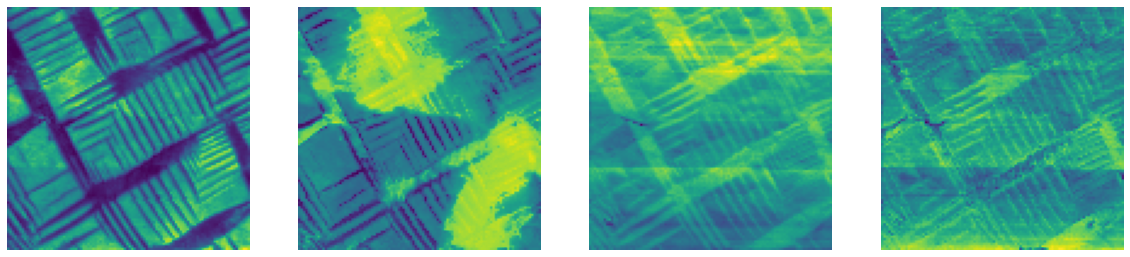

In [ ]:
# DKL inputs
amplitude = BEPS['Image_Amplitude'].astype(np.float64)
phase = BEPS["Image_Phase"].astype(np.float64)
frequency = BEPS["Image_Frequency"].astype(np.float64)
qfactor = BEPS["Image_Q_Factor"].astype(np.float64)
# DKL targets
loop_area = BEPS['Image_Off_Field_Loop_Area']

norm_ = lambda x: (x - x.min()) / x.ptp()

# Concatenate input channels
all_channels = np.concatenate(
    [
     norm_(amplitude)[..., None],
     norm_(phase)[..., None],
     norm_(frequency)[..., None],
     norm_(qfactor)[..., None]
     ], 
     axis=-1)
print(all_channels.shape, loop_area.shape)

# Plot
_, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(all_channels[..., i], origin='lower')
    ax.axis('off')

Create training data (patches with amplitude/phase/grequency/q-factor data as inputs and loop areas as target):

In [ ]:
indices_all, features_all, targets_all = create_training_set(all_channels, loop_area, 12)

#targets_all -= targets_all.mean()
#targets_all /= targets_all.std()

targets_all -= targets_all.min()
targets_all /= targets_all.ptp()

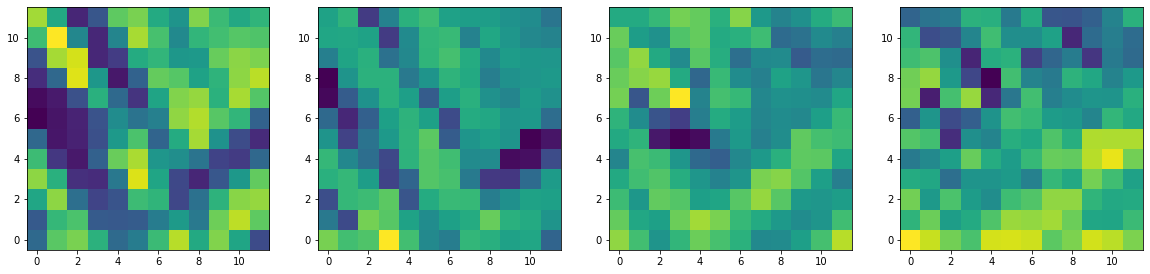

In [ ]:
k = 450

_, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(features_all[k ,..., i], origin='lower',)
    ax.imshow(features_all[k ,..., i], origin='lower')

Define helper functions for running Bayesian inference and active channel learning:

In [10]:
def step_mcmc(X, y, X_new):
    key1, key2 = gpax.utils.get_keys()
    data_dim = X.shape[-1]
    dkl = gpax.DKL(data_dim, z_dim=2, kernel='RBF')
    dkl.fit(key1, X, y, num_warmup=333, num_samples=333, num_chains=3, chain_method='vectorized')
    mean, samples = dkl.predict_in_batches(key2, X_new)
    var = samples.squeeze().var(0)
    return mean, var


def get_best_channel(record):
    return record[:,1].argmax()


def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record


def get_reward(obj_history, obj):
    """A reward of +/-1 is given if the integral uncertainty at the current step
    is smaller/larger than the integral uncertainty at the previous step"""
    if jnp.nansum(obj) < obj_history[-1]:
        r = 1
    else:
        r = -1
    return r


def update_datapoints(next_point_idx, train, test):
    X_train, y_train, indices_train = train
    X_test, y_test, indices_test = test
    X_train = jnp.append(X_train, X_test[:, next_point_idx:next_point_idx+1], axis=1)
    X_test = jnp.delete(X_test, next_point_idx, axis=1)
    y_train = jnp.append(y_train, y_test[:, next_point_idx:next_point_idx+1], axis=-1)
    y_test = jnp.delete(y_test, next_point_idx, axis=-1)
    indices_train = jnp.append(indices_train, indices_test[next_point_idx:next_point_idx+1], axis=0)
    indices_test = jnp.delete(indices_test, next_point_idx, axis=0)
    return (X_train, y_train, indices_train), (X_test, y_test, indices_test)

Create training and 'unmeasured' dataset. We start with having only 0.5% of the grid points 'measured'.

In [ ]:
n, h, w, c = features_all.shape
features_all = features_all.reshape(n, h*w, c)

(X_train, X_unmeasured, y_train, y_unmeasured,
 indices_train, indices_unmeasured) = train_test_split(
    features_all, targets_all, indices_all, test_size=0.99, random_state=1)

X_train = X_train.transpose(2, 0, 1)
X_unmeasured = X_unmeasured.transpose(2, 0, 1)
y_train = y_train[None].repeat(X_train.shape[0], axis=0)
y_unmeasured = y_unmeasured[None].repeat(X_train.shape[0], axis=0)

X_train.shape, X_unmeasured.shape, y_train.shape, y_unmeasured.shape

((4, 79, 144), (4, 7842, 144), (4, 79), (4, 7842))

Run active channel learning:

Warmup step 1/5


sample: 100%|██████████| 666/666 [20:36<00:00,  1.86s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.65      6.66      5.20      1.12     15.83    124.52      1.01
k_length[0,1]      7.41      6.20      5.29      1.09     15.20    143.70      1.01
k_length[1,0]      6.46      6.00      4.37      1.30     13.37    177.93      1.01
k_length[1,1]      6.37      5.60      4.46      0.93     13.08    179.68      1.00
k_length[2,0]      6.01      5.38      4.41      0.57     12.00    146.79      1.01
k_length[2,1]      4.24      4.60      2.57      0.49      9.67    133.14      1.05
k_length[3,0]      5.12      5.29      3.32      0.60     10.30    339.00      1.01
k_length[3,1]      4.71      4.36      3.29      0.70      9.87    299.90      1.00
   k_scale[0]      0.21      0.21      0.15      0.04      0.39    545.33      1.00
   k_scale[1]      0.25      0.19      0.18      0.05      0.49    431.77      1.00
   k_scale[2]      0.28      0.26      0.20      0.04      0.55    555.78  

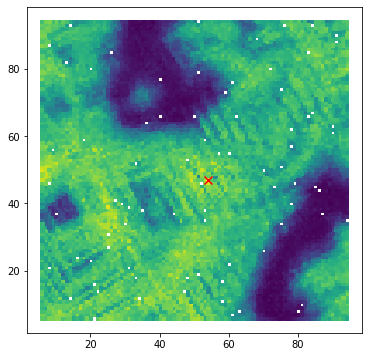

Warmup step 2/5


sample: 100%|██████████| 666/666 [20:16<00:00,  1.83s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.01      6.38      4.81      1.06     14.28     68.24      1.04
k_length[0,1]      8.36      7.45      5.94      1.59     16.67    104.35      1.02
k_length[1,0]      5.87      5.54      4.10      1.10     11.48    142.60      1.03
k_length[1,1]      6.28      5.19      4.52      0.95     12.46    146.18      1.02
k_length[2,0]      5.76      6.52      3.78      0.61     12.56    212.28      1.01
k_length[2,1]      5.03      4.75      3.23      0.45     11.11    116.87      1.01
k_length[3,0]      4.73      4.89      2.82      0.69     10.69     80.24      1.02
k_length[3,1]      5.36      5.96      3.39      0.29     12.41     87.49      1.02
   k_scale[0]      0.21      0.21      0.16      0.04      0.37    494.01      1.00
   k_scale[1]      0.24      0.21      0.18      0.04      0.46    577.60      1.00
   k_scale[2]      0.31      0.26      0.23      0.03      0.67    302.70  

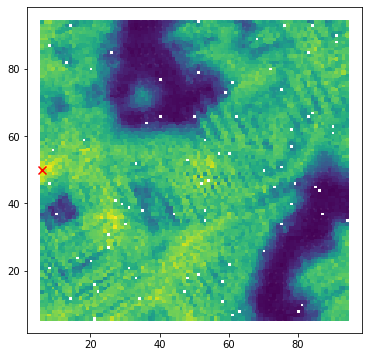

Warmup step 3/5


sample: 100%|██████████| 666/666 [20:59<00:00,  1.89s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.51      6.94      5.05      0.98     16.15     66.18      1.04
k_length[0,1]      8.43      8.30      5.68      0.97     17.50     95.33      1.03
k_length[1,0]      6.79      6.49      4.62      1.29     13.79    114.86      1.00
k_length[1,1]      6.29      5.08      4.74      1.03     11.93    129.11      1.01
k_length[2,0]      4.94      5.01      3.03      0.26     11.23     81.28      1.01
k_length[2,1]      5.89      6.09      3.81      0.41     12.46     71.91      1.02
k_length[3,0]      5.42      5.26      3.52      0.53     11.96    178.48      1.00
k_length[3,1]      4.88      5.25      2.91      0.51     11.64     89.41      1.01
   k_scale[0]      0.20      0.18      0.15      0.04      0.39    360.75      1.00
   k_scale[1]      0.26      0.24      0.19      0.03      0.49    498.69      1.00
   k_scale[2]      0.30      0.28      0.21      0.03      0.61    220.40  

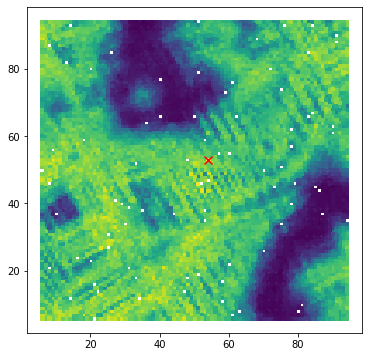

Warmup step 4/5


sample: 100%|██████████| 666/666 [21:16<00:00,  1.92s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.64      6.64      5.43      1.27     15.19    119.77      1.02
k_length[0,1]      7.60      7.29      5.01      1.45     15.10     83.57      1.04
k_length[1,0]      6.54      6.73      4.43      1.10     13.10    108.27      1.03
k_length[1,1]      7.33      6.63      4.67      0.99     15.80    115.38      1.03
k_length[2,0]      5.64      6.36      3.72      0.50     11.63    177.36      1.01
k_length[2,1]      5.06      5.22      3.30      0.46     10.90    138.11      1.01
k_length[3,0]      5.30      6.02      3.25      0.42     11.71    150.47      1.02
k_length[3,1]      4.66      4.82      2.85      0.53     10.56    140.15      1.02
   k_scale[0]      0.21      0.28      0.15      0.05      0.38    512.29      1.00
   k_scale[1]      0.24      0.20      0.18      0.04      0.49    522.89      1.01
   k_scale[2]      0.31      0.30      0.23      0.05      0.60    366.96  

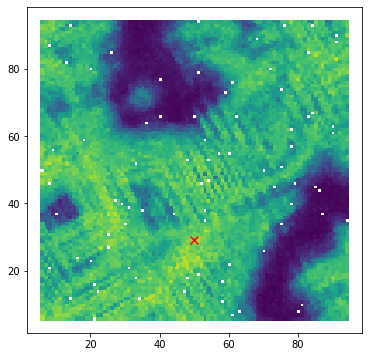

Warmup step 5/5


sample: 100%|██████████| 666/666 [21:04<00:00,  1.90s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.94      8.40      4.89      1.43     17.57     29.63      1.13
k_length[0,1]      9.07      8.39      6.28      1.71     17.89     25.83      1.13
k_length[1,0]      6.92      8.89      4.45      0.73     12.90     99.06      1.04
k_length[1,1]      7.12      6.59      5.02      1.37     14.36    103.18      1.01
k_length[2,0]      6.64      6.63      4.65      0.86     15.24     43.60      1.06
k_length[2,1]      4.00      4.49      2.16      0.38      9.66      9.02      1.14
k_length[3,0]      4.97      5.48      3.06      0.59     10.91     63.48      1.07
k_length[3,1]      4.78      5.10      2.60      0.37     11.37     60.72      1.04
   k_scale[0]      0.21      0.20      0.15      0.04      0.37    289.68      1.01
   k_scale[1]      0.24      0.21      0.18      0.04      0.46    451.61      1.00
   k_scale[2]      0.29      0.24      0.21      0.04      0.59    255.03  

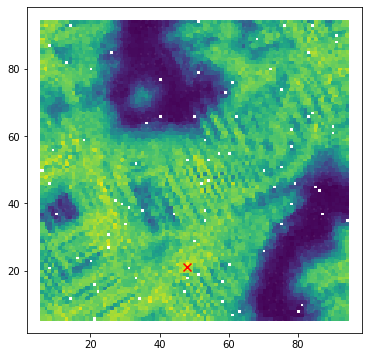


Exploration step 1/30
Using channel 4


sample: 100%|██████████| 666/666 [16:39<00:00,  1.50s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      5.09      6.49      2.60      0.39     11.89     94.58      1.05
k_length[0,1]      6.06      7.00      3.61      0.58     14.23    166.89      1.03
   k_scale[0]      0.23      0.22      0.17      0.05      0.41    607.87      1.01
     noise[0]      0.01      0.01      0.01      0.00      0.02     27.08      1.12



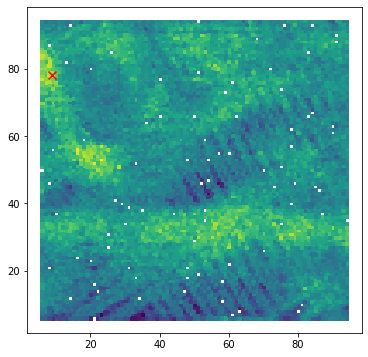


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 5  reward (avg) 1.0
channel 3:  counts 5  reward (avg) 0.0
channel 4:  counts 6  reward (avg) -0.167

Exploration step 2/30
Using channel 2


sample: 100%|██████████| 666/666 [16:20<00:00,  1.47s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.00      8.18      5.14      1.10     16.85    132.21      1.03
k_length[0,1]      6.50      6.28      4.43      1.16     13.04    265.19      1.01
   k_scale[0]      0.24      0.22      0.18      0.04      0.45    656.77      1.00
     noise[0]      0.01      0.00      0.01      0.00      0.01    487.86      1.00



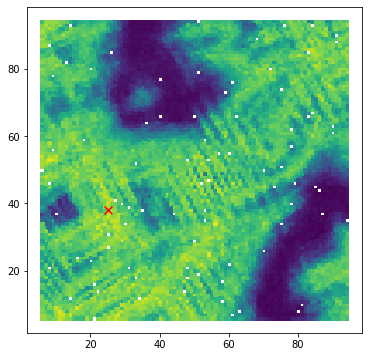


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 6  reward (avg) 1.0
channel 3:  counts 5  reward (avg) 0.0
channel 4:  counts 6  reward (avg) -0.167

Exploration step 3/30
Using channel 2


sample: 100%|██████████| 666/666 [16:43<00:00,  1.51s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.87      6.44      4.74      1.32     14.21    157.10      1.03
k_length[0,1]      7.18      7.28      4.87      1.12     14.27    174.03      1.03
   k_scale[0]      0.24      0.20      0.18      0.04      0.46    510.33      1.00
     noise[0]      0.01      0.00      0.01      0.00      0.01    515.93      1.00



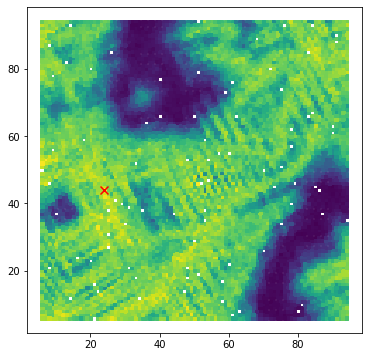


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 7  reward (avg) 0.714
channel 3:  counts 5  reward (avg) 0.0
channel 4:  counts 6  reward (avg) -0.167

Exploration step 4/30
Using channel 2


sample: 100%|██████████| 666/666 [16:47<00:00,  1.51s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.87      6.28      4.72      1.02     13.65    156.98      1.01
k_length[0,1]      7.48      8.24      5.03      0.93     15.12    251.41      1.01
   k_scale[0]      0.25      0.24      0.18      0.04      0.49    602.29      1.00
     noise[0]      0.01      0.00      0.01      0.00      0.01    587.93      1.01



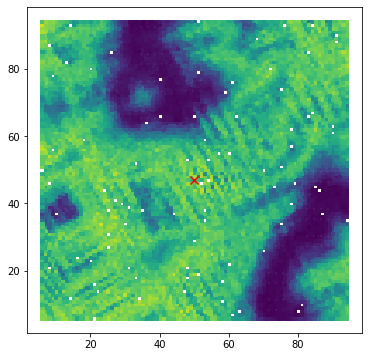


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 8  reward (avg) 0.75
channel 3:  counts 5  reward (avg) 0.0
channel 4:  counts 6  reward (avg) -0.167

Exploration step 5/30
Using channel 3


sample: 100%|██████████| 666/666 [16:32<00:00,  1.49s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      5.83      5.91      3.52      0.41     13.17     22.27      1.13
k_length[0,1]      4.64      4.24      3.31      0.64     10.83     18.68      1.17
   k_scale[0]      0.25      0.19      0.19      0.06      0.49     31.78      1.09
     noise[0]      0.01      0.01      0.01      0.00      0.02     36.34      1.06



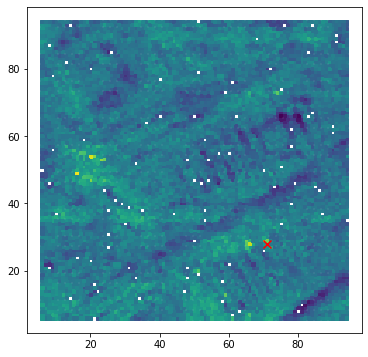


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 8  reward (avg) 0.75
channel 3:  counts 6  reward (avg) -0.167
channel 4:  counts 6  reward (avg) -0.167

Exploration step 6/30
Using channel 3


sample: 100%|██████████| 666/666 [17:04<00:00,  1.54s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.00      7.44      4.83      0.37     16.27     59.99      1.07
k_length[0,1]      4.23      5.21      2.02      0.33     10.71     38.99      1.08
   k_scale[0]      0.25      0.23      0.19      0.04      0.47    154.64      1.00
     noise[0]      0.01      0.01      0.01      0.00      0.02     45.66      1.03



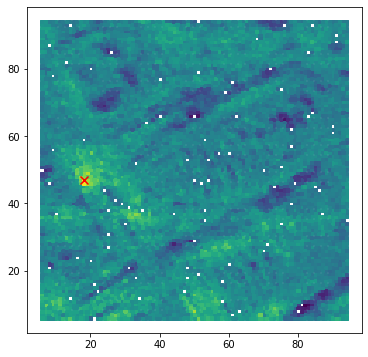


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 8  reward (avg) 0.75
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 7/30
Using channel 2


sample: 100%|██████████| 666/666 [16:59<00:00,  1.53s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.58      6.41      4.46      1.04     13.01    174.91      1.01
k_length[0,1]      7.52      7.10      5.23      1.30     14.95    164.90      1.01
   k_scale[0]      0.23      0.17      0.18      0.03      0.42    868.89      1.00
     noise[0]      0.01      0.00      0.01      0.00      0.01    362.27      1.01



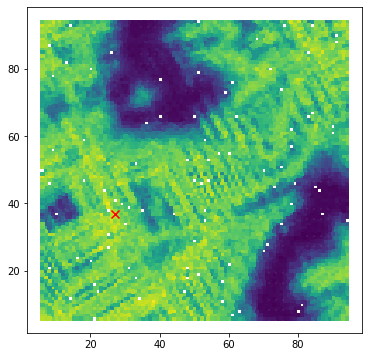


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 9  reward (avg) 0.778
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 8/30
Using channel 1


sample: 100%|██████████| 666/666 [11:38<00:00,  1.05s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]     10.20      9.45      7.29      1.33     19.75     30.15      1.06
k_length[0,1]      6.99      7.97      4.51      1.50     13.63     80.67      1.05
   k_scale[0]      0.20      0.16      0.15      0.04      0.39    602.96      1.00
     noise[0]      0.01      0.00      0.01      0.00      0.01    473.80      1.02



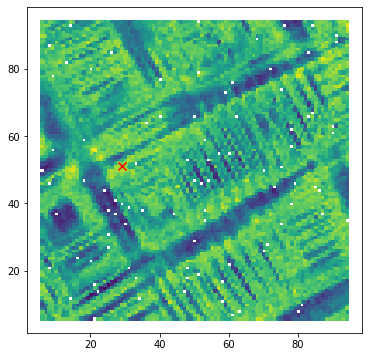


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 9  reward (avg) 0.778
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 9/30
Using channel 2


sample: 100%|██████████| 666/666 [17:11<00:00,  1.55s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.03      6.47      4.72      0.76     15.01    179.58      1.02
k_length[0,1]      6.90      6.12      4.67      1.23     14.56    152.58      1.03
   k_scale[0]      0.23      0.20      0.18      0.04      0.46    661.90      1.00
     noise[0]      0.01      0.00      0.01      0.00      0.01    451.50      1.00



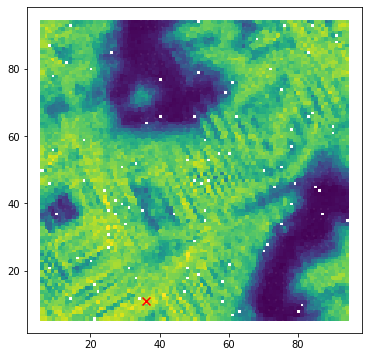


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 10  reward (avg) 0.8
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 10/30
Using channel 2


sample: 100%|██████████| 666/666 [17:04<00:00,  1.54s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.80      7.93      5.18      1.01     15.70    246.64      1.01
k_length[0,1]      6.88      6.63      4.56      1.26     14.66    177.99      1.01
   k_scale[0]      0.23      0.19      0.18      0.04      0.45    830.05      1.00
     noise[0]      0.01      0.00      0.01      0.00      0.01    521.82      1.00



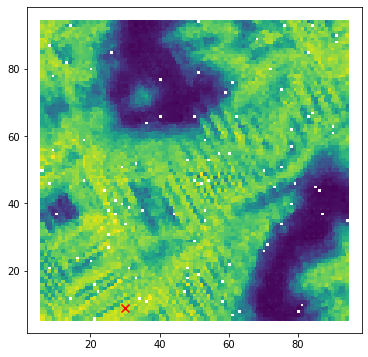


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 11  reward (avg) 0.818
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 11/30
Using channel 4


sample: 100%|██████████| 666/666 [17:32<00:00,  1.58s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.08      7.69      3.24      0.31     13.36    115.03      1.00
k_length[0,1]      5.29      5.88      2.71      0.45     12.56     73.31      1.03
   k_scale[0]      0.21      0.18      0.16      0.04      0.41    471.00      1.00
     noise[0]      0.01      0.01      0.01      0.00      0.02     72.70      1.04



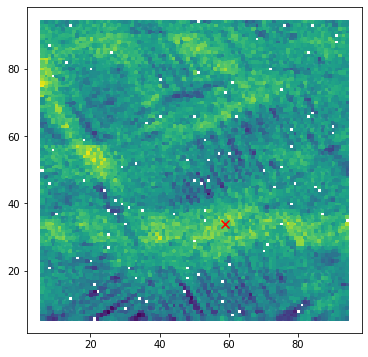


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 11  reward (avg) 0.818
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 12/30
Using channel 2


sample: 100%|██████████| 666/666 [17:08<00:00,  1.54s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.12      8.74      5.16      1.19     16.89    242.96      1.01
k_length[0,1]      7.25      7.78      4.98      1.06     13.95    228.58      1.01
   k_scale[0]      0.24      0.22      0.19      0.04      0.45    648.77      1.00
     noise[0]      0.01      0.00      0.01      0.00      0.01    586.95      1.00



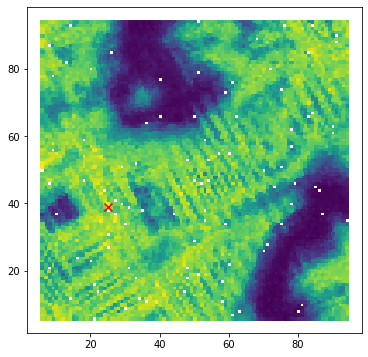


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 12  reward (avg) 0.833
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 13/30
Using channel 2


sample: 100%|██████████| 666/666 [16:36<00:00,  1.50s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.89      6.75      4.51      1.47     14.85    168.06      1.01
k_length[0,1]      8.47      8.36      5.49      1.40     17.67    203.52      1.00
   k_scale[0]      0.24      0.21      0.19      0.04      0.45    742.90      1.00
     noise[0]      0.01      0.00      0.01      0.00      0.01    569.46      1.00



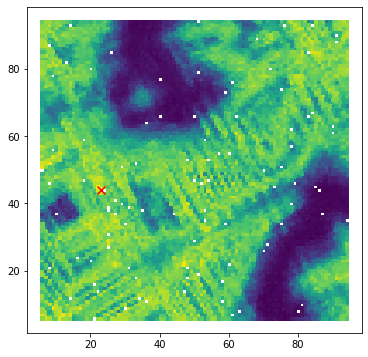


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 13  reward (avg) 0.846
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 14/30
Using channel 2


sample: 100%|██████████| 666/666 [17:37<00:00,  1.59s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.42      7.41      4.64      1.08     16.39    172.40      1.01
k_length[0,1]      7.70      7.34      5.00      1.15     16.42    141.45      1.02
   k_scale[0]      0.23      0.19      0.17      0.04      0.42    764.37      1.00
     noise[0]      0.01      0.00      0.00      0.00      0.01    436.02      1.00



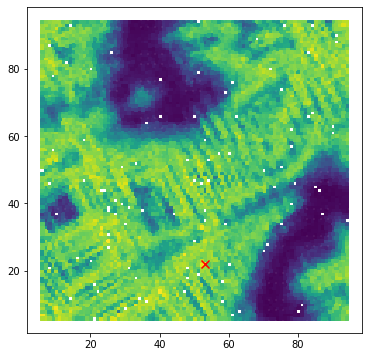


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 14  reward (avg) 0.714
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 15/30
Using channel 2


sample: 100%|██████████| 666/666 [18:13<00:00,  1.64s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.40      7.65      4.60      1.21     15.70     71.71      1.03
k_length[0,1]      8.12      8.10      5.43      1.11     17.30     94.73      1.02
   k_scale[0]      0.23      0.19      0.18      0.04      0.44    580.67      1.00
     noise[0]      0.01      0.00      0.00      0.00      0.01    481.00      1.00



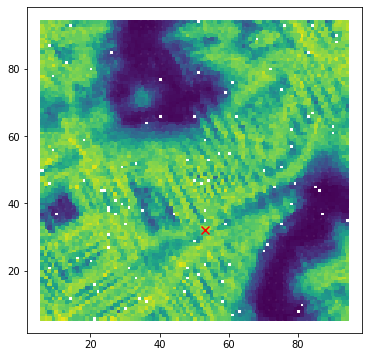


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 15  reward (avg) 0.733
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 16/30
Using channel 2


sample: 100%|██████████| 666/666 [17:46<00:00,  1.60s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.06      7.69      5.28      1.29     17.68    106.12      1.06
k_length[0,1]      7.73      8.49      4.86      1.28     17.15    156.16      1.04
   k_scale[0]      0.23      0.19      0.17      0.04      0.43    398.20      1.00
     noise[0]      0.01      0.00      0.00      0.00      0.01    327.33      1.01



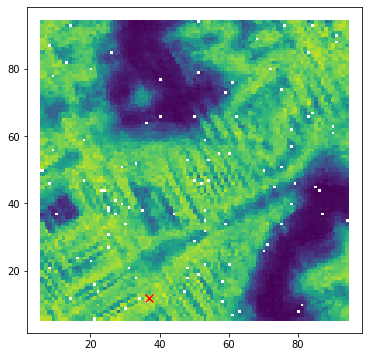


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 16  reward (avg) 0.75
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 17/30
Using channel 2


sample: 100%|██████████| 666/666 [17:41<00:00,  1.59s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.61      7.59      4.95      1.21     15.82     33.17      1.05
k_length[0,1]      7.48      7.70      4.88      1.42     16.58     60.75      1.05
   k_scale[0]      0.24      0.19      0.19      0.04      0.46    255.13      1.01
     noise[0]      0.01      0.00      0.00      0.00      0.01    473.29      1.00



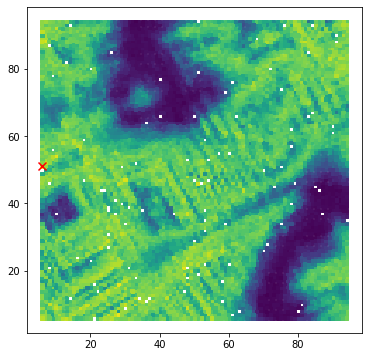


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 17  reward (avg) 0.647
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 18/30
Using channel 2


sample: 100%|██████████| 666/666 [17:50<00:00,  1.61s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.80      7.80      4.56      1.01     13.08    188.51      1.03
k_length[0,1]      8.99      7.30      6.62      1.22     17.77    146.26      1.02
   k_scale[0]      0.24      0.21      0.18      0.05      0.46    621.95      1.01
     noise[0]      0.00      0.00      0.00      0.00      0.01    318.98      1.01



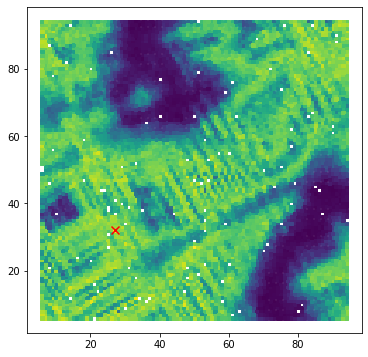


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 18  reward (avg) 0.667
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 19/30
Using channel 1


sample: 100%|██████████| 666/666 [17:10<00:00,  1.55s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]     10.18      9.66      6.79      1.86     21.15    143.37      1.01
k_length[0,1]      9.05      8.69      5.85      1.57     19.14    111.90      1.02
   k_scale[0]      0.21      0.19      0.15      0.03      0.41    372.34      1.01
     noise[0]      0.01      0.00      0.00      0.00      0.01    414.61      1.00



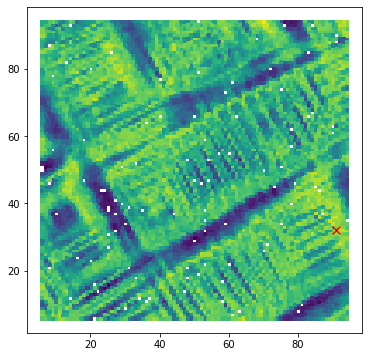


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 18  reward (avg) 0.667
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 20/30
Using channel 2


sample: 100%|██████████| 666/666 [17:53<00:00,  1.61s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.76      7.06      4.92      1.40     17.00    123.53      1.04
k_length[0,1]      7.90      7.20      5.14      1.43     16.86     99.18      1.05
   k_scale[0]      0.25      0.21      0.18      0.04      0.47    568.94      1.01
     noise[0]      0.00      0.00      0.00      0.00      0.01    222.07      1.02



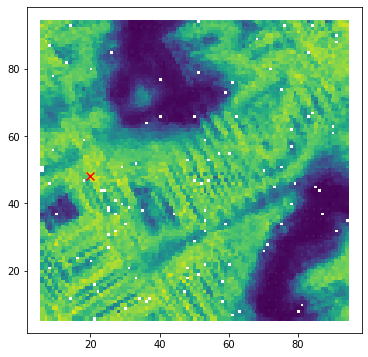


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 19  reward (avg) 0.684
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 21/30
Using channel 2


sample: 100%|██████████| 666/666 [17:24<00:00,  1.57s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.92      7.94      4.82      1.29     17.11     89.47      1.03
k_length[0,1]      8.02      7.05      5.24      1.55     17.26    107.35      1.03
   k_scale[0]      0.23      0.17      0.18      0.05      0.41    834.79      1.00
     noise[0]      0.00      0.00      0.00      0.00      0.01    350.07      1.01



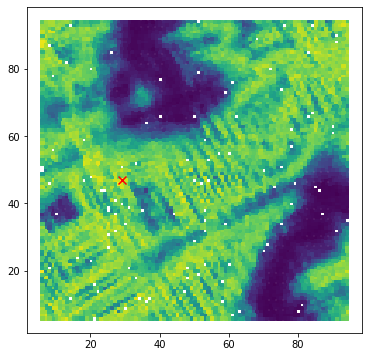


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 20  reward (avg) 0.7
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 22/30
Using channel 2


sample: 100%|██████████| 666/666 [18:15<00:00,  1.64s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.99      9.12      5.61      1.37     19.50     65.78      1.05
k_length[0,1]      7.21      7.21      4.71      1.48     15.59     72.67      1.05
   k_scale[0]      0.22      0.20      0.17      0.05      0.40    416.69      1.01
     noise[0]      0.00      0.00      0.00      0.00      0.01    290.90      1.01



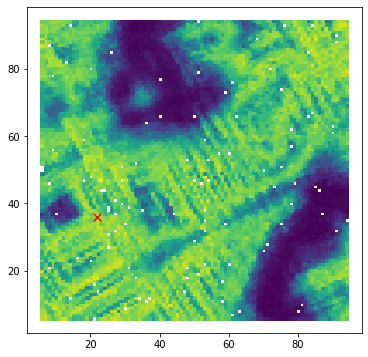


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 21  reward (avg) 0.619
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 23/30
Using channel 2


sample: 100%|██████████| 666/666 [18:29<00:00,  1.67s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.53      7.56      5.68      1.35     18.84    106.66      1.03
k_length[0,1]      7.37      7.32      4.74      1.25     15.39     66.47      1.06
   k_scale[0]      0.23      0.20      0.17      0.04      0.43    469.97      1.01
     noise[0]      0.00      0.00      0.00      0.00      0.01    337.31      1.00



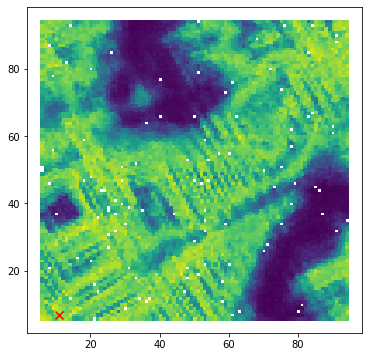


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 22  reward (avg) 0.545
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 24/30
Using channel 2


sample: 100%|██████████| 666/666 [18:19<00:00,  1.65s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      9.25      8.73      6.14      0.87     20.52     76.56      1.06
k_length[0,1]      7.08      6.71      4.54      1.13     15.27     68.22      1.05
   k_scale[0]      0.23      0.20      0.17      0.03      0.44    595.81      1.00
     noise[0]      0.00      0.00      0.00      0.00      0.01    309.22      1.01



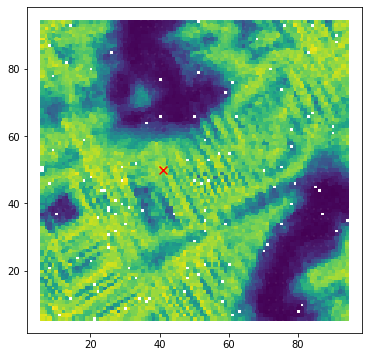


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 23  reward (avg) 0.565
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 25/30
Using channel 2


sample: 100%|██████████| 666/666 [18:14<00:00,  1.64s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.07      7.80      5.32      0.97     17.11    104.82      1.03
k_length[0,1]      7.97      7.82      5.15      1.49     16.99     95.44      1.04
   k_scale[0]      0.23      0.20      0.18      0.04      0.44    572.08      1.00
     noise[0]      0.00      0.00      0.00      0.00      0.01    294.96      1.02



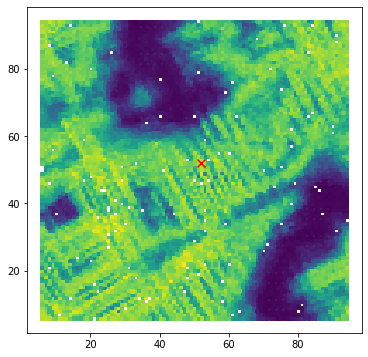


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 24  reward (avg) 0.583
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 26/30
Using channel 2


sample: 100%|██████████| 666/666 [18:33<00:00,  1.67s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      9.07      8.95      5.88      1.48     18.97     89.87      1.02
k_length[0,1]      7.56      7.95      4.49      1.16     16.33     99.48      1.02
   k_scale[0]      0.23      0.18      0.18      0.04      0.42    402.16      1.02
     noise[0]      0.00      0.00      0.00      0.00      0.01    203.89      1.01



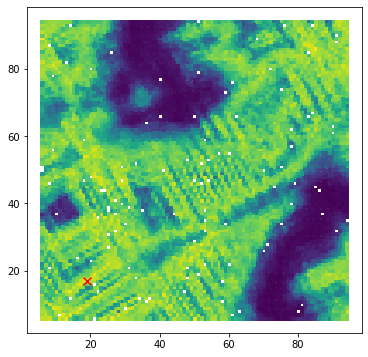


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 25  reward (avg) 0.6
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 27/30
Using channel 2


sample: 100%|██████████| 666/666 [18:35<00:00,  1.67s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      7.81      7.16      5.22      1.44     16.16    127.77      1.02
k_length[0,1]      7.95      8.01      4.92      1.42     16.80    103.17      1.02
   k_scale[0]      0.23      0.19      0.18      0.04      0.43    935.50      1.00
     noise[0]      0.00      0.00      0.00      0.00      0.01    307.89      1.01



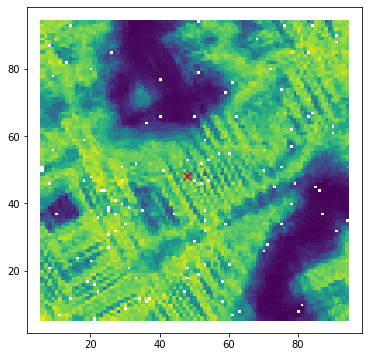


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 26  reward (avg) 0.615
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 28/30
Using channel 2


sample: 100%|██████████| 666/666 [18:41<00:00,  1.68s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.75      9.19      5.14      1.36     20.18    100.88      1.03
k_length[0,1]      7.75      7.37      5.22      1.53     16.05     82.76      1.04
   k_scale[0]      0.23      0.19      0.17      0.03      0.43    603.94      1.00
     noise[0]      0.00      0.00      0.00      0.00      0.01    270.25      1.02



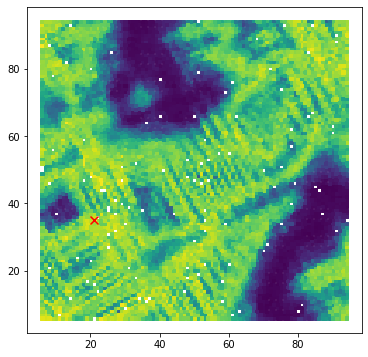


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 27  reward (avg) 0.556
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 29/30
Using channel 2


sample: 100%|██████████| 666/666 [17:55<00:00,  1.61s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.65      8.33      5.77      1.42     18.52    150.03      1.01
k_length[0,1]      7.43      7.28      4.84      1.33     16.02     83.56      1.05
   k_scale[0]      0.26      0.21      0.20      0.04      0.48    481.47      1.00
     noise[0]      0.00      0.00      0.00      0.00      0.01    206.47      1.01



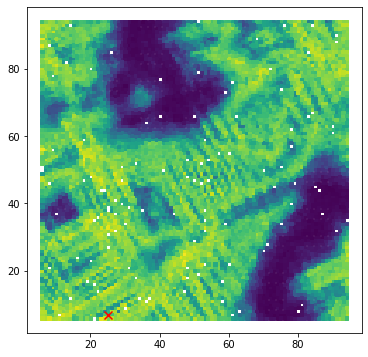


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 28  reward (avg) 0.5
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 30/30
Using channel 2


sample: 100%|██████████| 666/666 [18:49<00:00,  1.70s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      8.99      7.88      6.48      1.20     18.23    160.91      1.01
k_length[0,1]      6.79      6.17      4.69      1.31     14.54     62.63      1.05
   k_scale[0]      0.26      0.24      0.19      0.05      0.51    226.06      1.01
     noise[0]      0.00      0.00      0.00      0.00      0.01    233.25      1.00



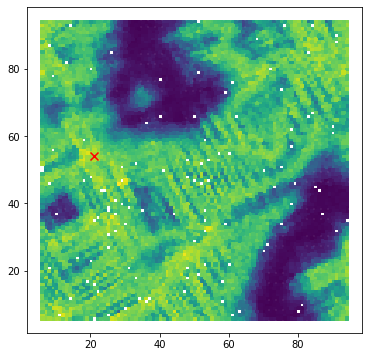


Rewards:
channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 29  reward (avg) 0.448
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286


In [ ]:
warmup_steps = 5
exploration_steps = 30
# epsilon in epsilon-greedy policy
#eps = np.ones(exploration_steps) * 0.4  # constant
eps = np.linspace(0.4, 0.1, exploration_steps)  # annealing

np.random.seed(55)  # rng seed for epsilon-greedy sampling
record = np.zeros((X_train.shape[0], 2))
channel_choices = []
var_history = []


def plot_acq():
    p = indices_unmeasured[next_point_idx]
    plt.figure(figsize=(6, 6))
    plt.scatter(indices_unmeasured[:, 1], indices_unmeasured[:, 0], c=obj, s=10, marker='s')
    plt.scatter(p[1], p[0], marker='x', s=64, c='red')
    plt.show()
    
# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    # Get/update DKL posterior
    mean, var = step_mcmc(X_train, y_train, X_unmeasured)
    record[:, 0] += 1
    # Select channel that resulted in lowest predictive uncertainty
    var_reduced = np.nansum(var, axis=-1)
    idx = np.argmin(var_reduced)
    # Update records
    var_history.append(var_reduced[idx].item())
    channel_choices.append(idx)
    record[idx, 1] += 1
    # compute the acquisition function for the selected channel
    #obj = mean[idx] + 2*var[idx]
    obj = var[idx]
    # get the next measurement point
    next_point_idx = obj.argmax()
    plot_acq()
    # Do "measurement"
    measured_point = y_unmeasured[:, next_point_idx]
    # update datapoints
    (X_train, y_train, indices_train), (X_unmeasured, y_unmeasured, indices_unmeasured) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_unmeasured, y_unmeasured, indices_unmeasured)
        )

# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

# Exploration-exploitation phase
for e in range(exploration_steps):
    print("\nExploration step {}/{}".format(e+1, exploration_steps))
    # Choose channel according to epsilon-greedy policy
    eps_i = eps[e] if e < exploration_steps else eps[-1]
    if np.random.random() > eps_i: 
        idx = get_best_channel(record)
    else:
        idx = np.random.randint(record.shape[0])
    channel_choices.append(idx)
    print("Using channel {}".format(idx+1))
    # Update DKL posterior using the sampled channel
    mean, var = step_mcmc(X_train[idx], y_train[idx], X_unmeasured[idx])
    # Get reward
    r = get_reward(var_history, var)
    # Update records
    record = update_record(record, idx, r)
    var_history.append(jnp.nansum(var).item())
    # Compute acqusition function and do measurement in the suggested point
    #obj = mean + 2*var
    obj = var
    next_point_idx = obj.argmax()
    plot_acq()
    measured_point = y_unmeasured[:, next_point_idx]
    # update datapoints
    (X_train, y_train, indices_train), (X_unmeasured, y_unmeasured, indices_unmeasured) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_unmeasured, y_unmeasured, indices_unmeasured)
        )
    # Print the running rewards
    print("\nRewards:")
    for i, r in enumerate(record):
        print("channel {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

    # Store current points
    np.savez("hmcDKL_channels_polar_norm01.npz",
         X_train=X_train, y_train=y_train, X_unmeasured=X_unmeasured,
         y_unmeasured=y_unmeasured, indices_unmeasured=indices_unmeasured,
         indices_measured=indices_train, record=record, channels_id=channel_choices,
         var_history=var_history)

In [5]:
dataset = np.load("hmcDKL_channels_polar_norm01.npz")

X_train=dataset["X_train"]
y_train=dataset["y_train"]
X_unmeasured=dataset["X_unmeasured"]
y_unmeasured=dataset["y_unmeasured"]
indices_unmeasured=dataset["indices_unmeasured"]
indices_train=dataset["indices_measured"]
record=dataset["record"]
channel_choices=dataset["channels_id"].tolist()
var_history=dataset["var_history"].tolist()

View the results:

In [6]:
for i, r in enumerate(record):
    print("channel {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

channel 1:  counts 7  reward (avg) -0.286
channel 2:  counts 29  reward (avg) 0.448
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286


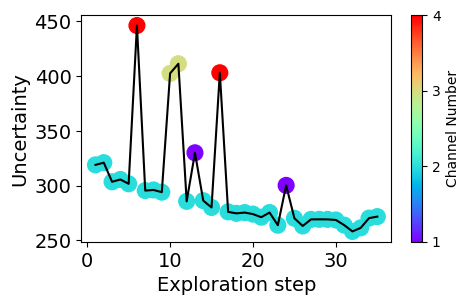

In [9]:
plt.figure(figsize = (5, 3), dpi=100)
plt.plot(np.arange(1, exploration_steps+warmup_steps+1), var_history, c='k')
plt.scatter(np.arange(1, exploration_steps+warmup_steps+1), var_history,
            c=[m+1 for m in channel_choices],
            s=128, cmap='rainbow', alpha=1)
plt.xlabel("Exploration step", fontsize=14)
plt.ylabel("Uncertainty", fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
cbar = plt.colorbar(label = "Channel Number")
cbar.set_ticks([1, 2, 3, 4])

Run DKL for all the channels and plot prediction:

In [11]:
mean, var = step_mcmc(X_train, y_train, X_unmeasured)

sample: 100%|██████████| 666/666 [29:42<00:00,  2.68s/it]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0,0]      6.04      4.32      4.79      2.05     10.29     40.34      1.06
k_length[0,1]     11.93      8.18      9.88      2.19     22.15     51.32      1.07
k_length[1,0]      5.70      5.26      4.12      1.54     10.31     53.43      1.04
k_length[1,1]     10.51      8.96      8.53      1.77     20.10    108.32      1.01
k_length[2,0]      8.44     11.94      5.60      0.83     16.22     51.53      1.08
k_length[2,1]      3.80      3.64      2.69      0.77      7.44     54.60      1.08
k_length[3,0]      4.33      5.02      2.50      0.70      9.84     41.81      1.06
k_length[3,1]      8.29      7.40      6.75      0.86     15.97     41.88      1.05
   k_scale[0]      0.21      0.18      0.16      0.04      0.38    176.10      1.01
   k_scale[1]      0.23      0.19      0.18      0.05      0.45    332.78      1.02
   k_scale[2]      0.38      0.29      0.28      0.06      0.77    129.45  

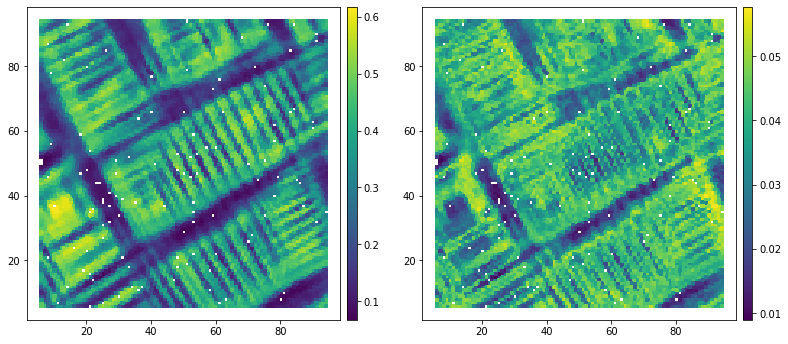

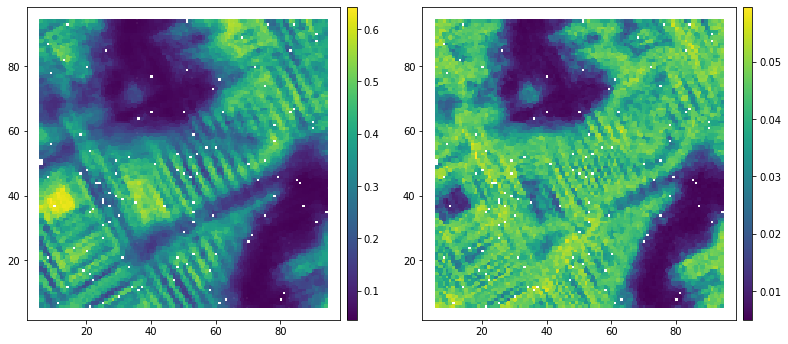

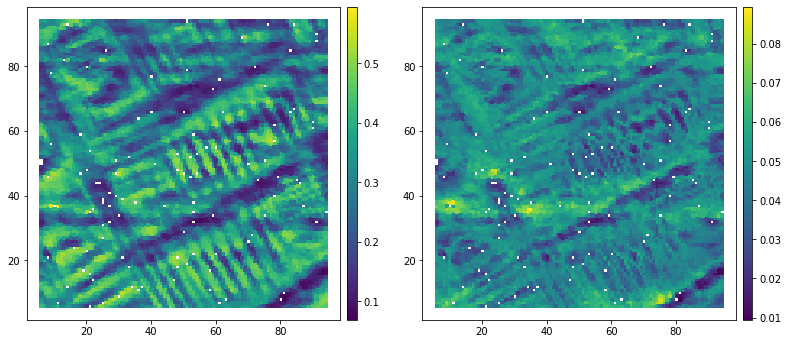

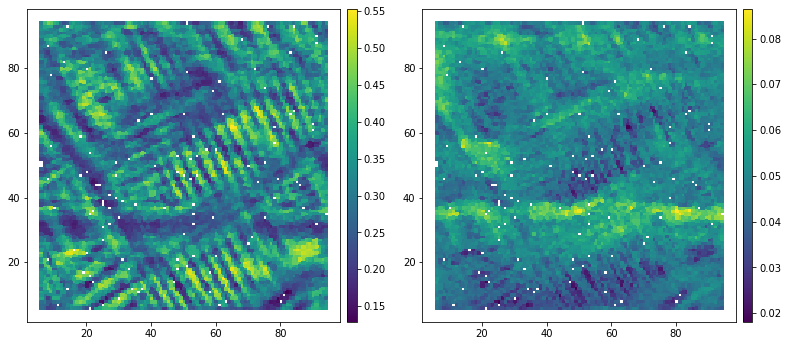

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for m, v in zip(mean, var):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    im1 = ax1.scatter(indices_unmeasured[:, 1], indices_unmeasured[:, 0], c=m, s=10, marker='s')
    ax1.set_aspect('equal')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    im2 = ax2.scatter(indices_unmeasured[:, 1], indices_unmeasured[:, 0], c=v, s=10, marker='s')
    ax2.set_aspect('equal')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    plt.show()

Error in prediction for two channels:

In [13]:
print(jnp.sum((abs(mean - y_unmeasured)), axis=-1))

[1184.67279246 1005.68638224 1411.77420842 1554.34109267]
